## Environment

In [29]:
import numpy as np
import pandas as pd
import graphviz as gr

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az
import statsmodels.formula.api as smf

In [2]:
SEED = sum(map(ord, "Statistical Rethinking, Lecture 6"))

In [3]:
rng = np.random.default_rng(seed=SEED)

## Confounder Mediator

Case of a known variable Z that mediates between a confounder and X

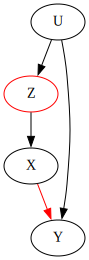

In [5]:
g = gr.Digraph()

g.edge("U", "Z")
g.edge("Z", "X")
g.edge("U", "Y")
g.edge("X", "Y", color="red")
g.node("Z", color="red")
g

### Simulate 

In [60]:
N = 300
b_XY = 0 # no actual relationship between X and Y
b_UY = -2
b_UZ = -2
b_ZX = 1

U = rng.normal(0, 5, size=N)
Z = rng.normal(loc=U*b_UZ)
X = rng.normal(loc=Z*b_ZX)
Y = rng.normal(loc=b_XY*X + b_UY*U)

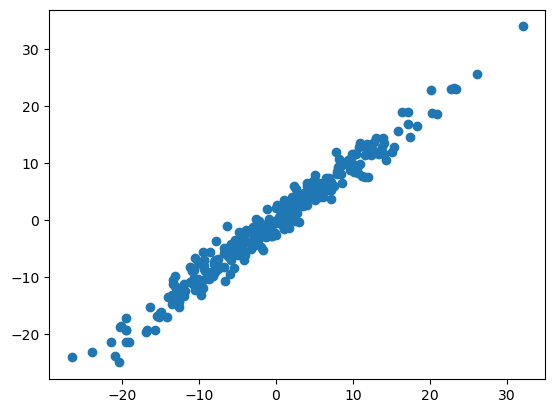

In [61]:
plt.plot(X, Y, marker="o", linestyle="")

### Model

#### Naive model ($X \sim Y$)

In [62]:
with pm.Model() as naive_m:
    
    a = pm.Normal("a", 0, 1)
    bxy = pm.Normal("bxy", 0, 1)
    
    sigma = pm.Exponential("sigma", lam=0.5)
    mu = pm.Deterministic("mu", a + bxy * X)
    
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=Y)
    
    idata_naive = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bxy, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'bxy'}>, <Axes: title={'center': 'bxy'}>]],
      dtype=object)

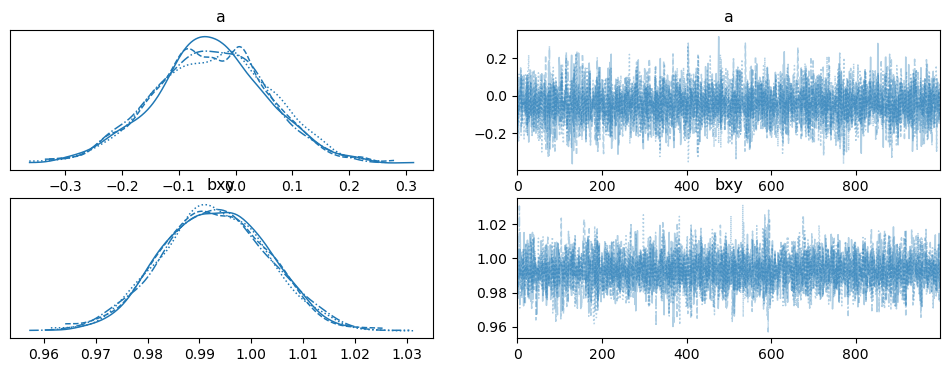

In [63]:
az.plot_trace(idata_naive, var_names=["a", "bxy"])

#### Controlled Model ($Y \sim X + Z$)

In [64]:
with pm.Model() as controlled_m:
    
    a = pm.Normal("a", 0, 1)
    bxy = pm.Normal("bxy", 0, 1)
    bz = pm.Normal("bz", 0, 1)
    
    sigma = pm.Exponential("sigma", lam=0.5)
    mu = pm.Deterministic("mu", a + bxy * X + bz * Z)
    
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=Y)
    
    idata_contr = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bxy, bz, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


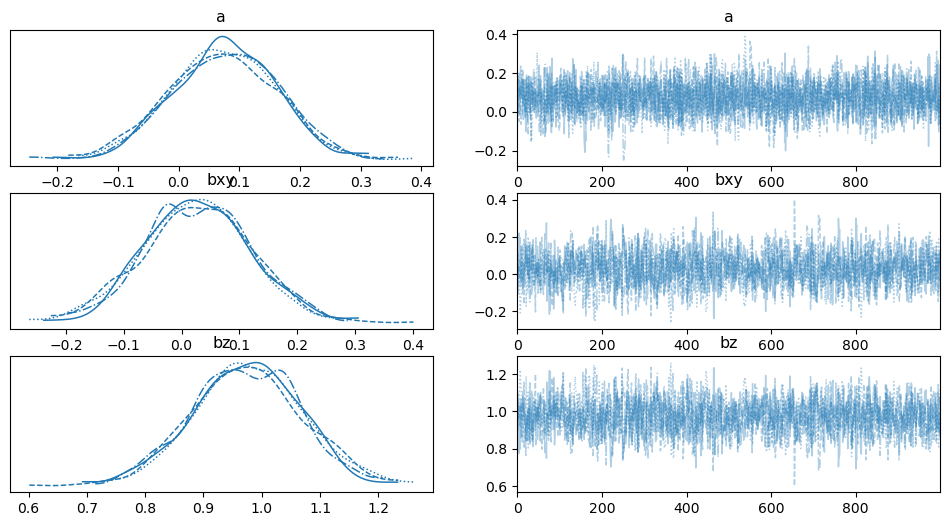

In [65]:
az.plot_trace(idata_contr, var_names=["a", "bxy", "bz"]);

### Simulate Bad Control

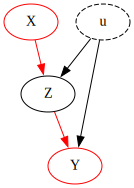

In [9]:
g = gr.Digraph()

g.edge("X", "Z", color="red")
g.edge("Z", "Y", color="red")
g.edge("u", "Z")
g.edge("u", "Y")
g.node("X", color="red")
g.node("Y", color="red")
g.node("u", style="dashed")

g

In [16]:
n=100
bXZ_true=1
bZY_true=1
bu_true=1
X = rng.normal(size=n)
u = rng.normal(size=n)
Z = rng.normal(loc=bXZ_true*X + bu_true*u)
Y = rng.normal(loc=bZY_true*Z + bu_true*u)
df = pd.DataFrame(np.c_[X, Y, Z, u], columns=["X", "Y", "Z", "u"])

In [21]:
smf.ols("Y ~ X", data=df).fit().params["X"]

1.3489142524365418

In [20]:
results.params

Intercept    0.051190
X            1.348914
dtype: float64

In [27]:
def simulate_model1(n=100, bXZ_true=1, bZY_true=1, bu_true=1):
    X = rng.normal(size=n)
    u = rng.normal(size=n)
    Z = rng.normal(loc=bXZ_true*X + bu_true*u)
    Y = rng.normal(loc=bZY_true*Z + bu_true*u)
    df = pd.DataFrame(np.c_[X, Y, Z, u], columns=["X", "Y", "Z", "u"])
    bX = smf.ols("Y ~ X", data=df).fit().params["X"]
    bXZ = smf.ols("Y ~ X + Z", data=df).fit().params["X"]
    return bX, bXZ

def run_experiment(N=10000, n=100, bXZ_true=1, bZY_true=1, bu_true=1):
    bXs = np.zeros(shape=N)
    bXZs = np.zeros(shape=N)
    for i in range(N):
        bXs[i], bXZs[i] = simulate_model1(n, bXZ_true, bZY_true, bu_true)
    return bXs, bXZs

In [32]:
bXs, bXZs = run_experiment(N=1000, n=100, bXZ_true=1, bZY_true=0, bu_true=1)

<Axes: ylabel='Density'>

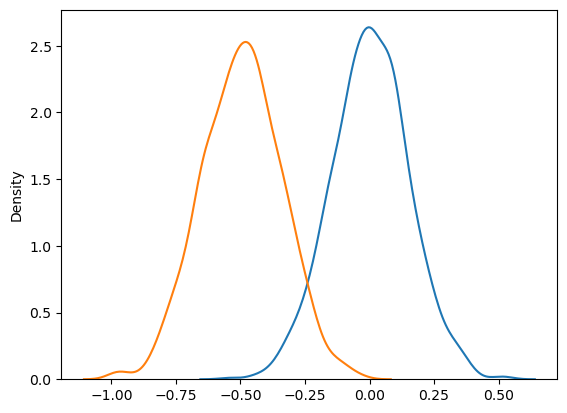

In [33]:
fig, ax = plt.subplots()
sns.kdeplot(x=bXs, ax=ax)
sns.kdeplot(x=bXZs, ax=ax)

In [35]:
def simulate_model2(n=100, bXY_true=1, bYZ_true=1):
    X = rng.normal(size=n)
    Y = rng.normal(loc=bXY_true*X)
    Z = rng.normal(loc=bYZ_true*Y)
    df = pd.DataFrame(np.c_[X, Y, Z], columns=["X", "Y", "Z"])
    bX = smf.ols("Y ~ X", data=df).fit().params["X"]
    bXZ = smf.ols("Y ~ X + Z", data=df).fit().params["X"]
    return bX, bXZ

def run_experiment(N=10000, n=100, bXY_true=1, bYZ_true=1):
    bXs = np.zeros(shape=N)
    bXZs = np.zeros(shape=N)
    for i in range(N):
        bXs[i], bXZs[i] = simulate_model2(n, bXY_true, bYZ_true)
    return bXs, bXZs

In [36]:
bXs, bXZs = run_experiment(N=1000, n=100, bXY_true=1, bYZ_true=1)

<Axes: ylabel='Density'>

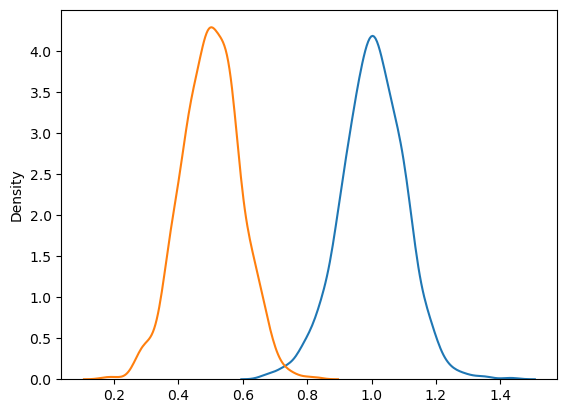

In [37]:
fig, ax = plt.subplots()
sns.kdeplot(x=bXs, ax=ax)
sns.kdeplot(x=bXZs, ax=ax)

In [86]:
def simulate_model3(n=100, bXY_true=1, bZX_true=1):
    Z = rng.binomial(n=1, p=0.5, size=n)
    X = rng.normal(loc=bZX_true*Z)
    Y = rng.normal(loc=bXY_true*X)
    df = pd.DataFrame(np.c_[X, Y, Z], columns=["X", "Y", "Z"])
    bX = smf.ols("Y ~ X", data=df).fit().params["X"]
    bXZ = smf.ols("Y ~ X + Z", data=df).fit().params["X"]
    return bX, bXZ

def run_experiment(N=10000, n=100, bXY_true=1, bZX_true=1):
    bXs = np.zeros(shape=N)
    bXZs = np.zeros(shape=N)
    for i in range(N):
        bXs[i], bXZs[i] = simulate_model3(n, bXY_true, bZX_true)
    return bXs, bXZs

In [109]:
bXs, bXZs = run_experiment(N=1000, n=100, bXY_true=1, bZX_true=4)

<Axes: ylabel='Density'>

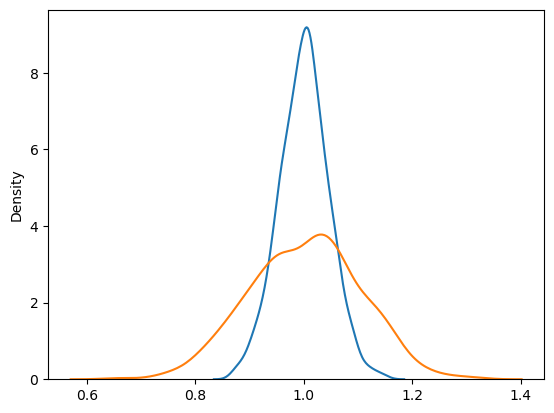

In [110]:
fig, ax = plt.subplots()
sns.kdeplot(x=bXs, ax=ax)
sns.kdeplot(x=bXZs, ax=ax)

In [111]:
bXs.std()

0.045671496293950425

In [112]:
bXZs.std()

0.10223694457750235

In [96]:
n = 1000
Z = rng.binomial(n=1, p=0.5, size=n)
X = rng.normal(loc=10*Z)
Y = rng.normal(loc=1*X)

<Axes: >

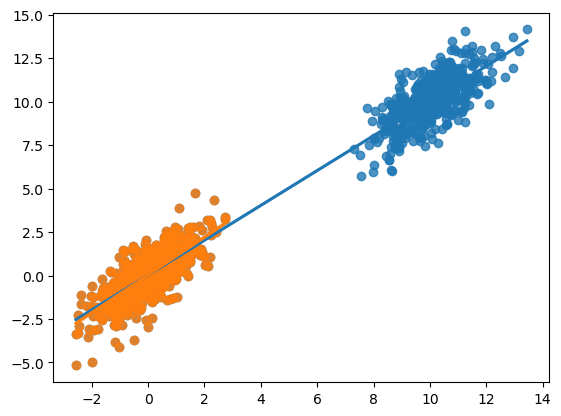

In [97]:
fig, ax = plt.subplots()
sns.regplot(
    x=X, 
    y=Y,
    ax=ax
    # hue=Z
)
sns.regplot(
    x=X[Z==0], 
    y=Y[Z==0],
    ax=ax
    # hue=Z
)

<Axes: >

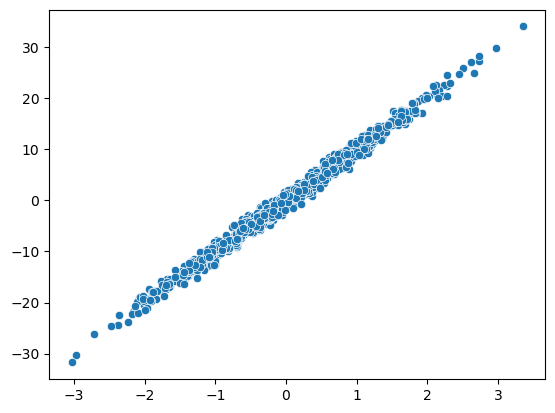

In [74]:
sns.scatterplot(x=Z, y=X)

<Axes: >

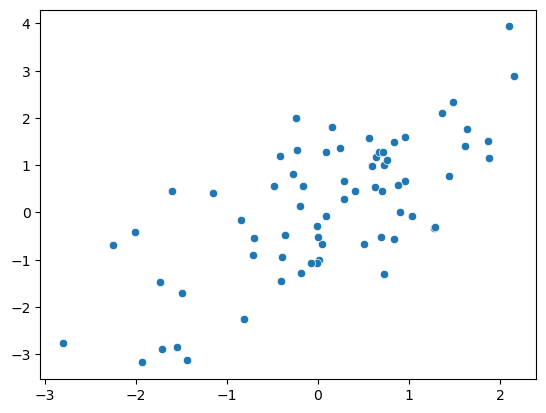

In [75]:
sns.scatterplot(
    x=X[(-0.1<Z) & (Z<0.1)],
    y=Y[(-0.1<Z) & (Z<0.1)]
)

In [136]:
def simulate_model4(n=100, bXY_true=1, bZX_true=1, bu_true=1):
    Z = rng.binomial(n=1, p=0.5, size=n)
    u = rng.normal(size=n)
    X = rng.normal(loc=bZX_true*Z + bu_true*u)
    Y = rng.normal(loc=bXY_true*X + bu_true*u)
    df = pd.DataFrame(np.c_[X, Y, Z, u], columns=["X", "Y", "Z", "u"])
    bX = smf.ols("Y ~ X", data=df).fit().params["X"]
    bXZ = smf.ols("Y ~ X + Z", data=df).fit().params["X"]
    return bX, bXZ

def run_experiment(N=1000, n=100, bXY_true=1, bZX_true=np.linspace(1, 20, 10), bu_true=1):
    means = np.zeros(shape=(len(bZX_true), 2))
    stds = np.zeros(shape=(len(bZX_true), 2))
    for j, b in enumerate(bZX_true):
        bXs = np.zeros(shape=N)
        bXZs = np.zeros(shape=N)
        for i in range(N):
            bXs[i], bXZs[i] = simulate_model4(n, bXY_true, b, bu_true)
        means[j, 0] = bXs.mean()
        means[j, 1] = bXZs.mean()
        stds[j, 0] = bXs.std()
        stds[j, 1] = bXZs.std()
    return means, stds

In [140]:
bZX_true=np.linspace(0, 20, 10)
means, stds = run_experiment(N=1000, n=100, bXY_true=0, bZX_true=bZX_true, bu_true=1)

In [138]:
bZX_true=np.linspace(0, 20, 10)

<Axes: >

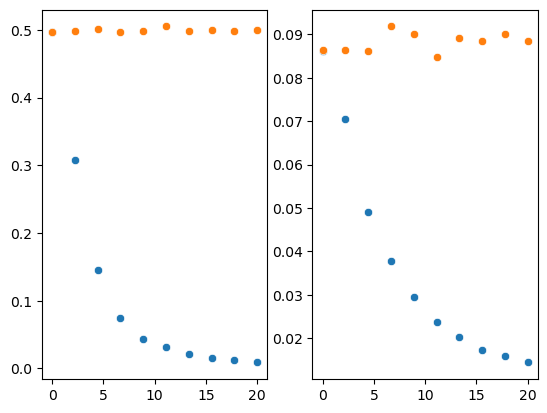

In [141]:
fig, axes = plt.subplots(1, 2)
sns.scatterplot(x=bZX_true, y=means[:, 0], ax=axes[0])
sns.scatterplot(x=bZX_true, y=means[:, 1], ax=axes[0])
sns.scatterplot(x=bZX_true, y=stds[:, 0], ax=axes[1])
sns.scatterplot(x=bZX_true, y=stds[:, 1], ax=axes[1])

In [146]:
n = 1000
bXY_true=0
bZX_true=7
bu_true=3
Z = rng.binomial(n=1, p=0.5, size=n)
u = rng.normal(size=n)
X = rng.normal(loc=bZX_true*Z + bu_true*u)
Y = rng.normal(loc=bXY_true*X + bu_true*u)

<Axes: >

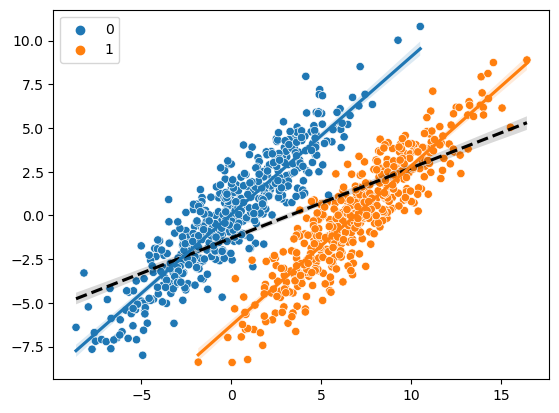

In [152]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=X,
    y=Y,
    hue=Z,
    ax=ax
)
sns.regplot(
    x=X, 
    y=Y,
    scatter=False,
    ax=ax,
    line_kws={"linestyle": "--"},
    color="k"
    # hue=Z
)
sns.regplot(
    x=X[Z==0], 
    y=Y[Z==0],
    scatter=False,
    ax=ax
)
sns.regplot(
    x=X[Z==1], 
    y=Y[Z==1],
    scatter=False,
    ax=ax
)

<Axes: >

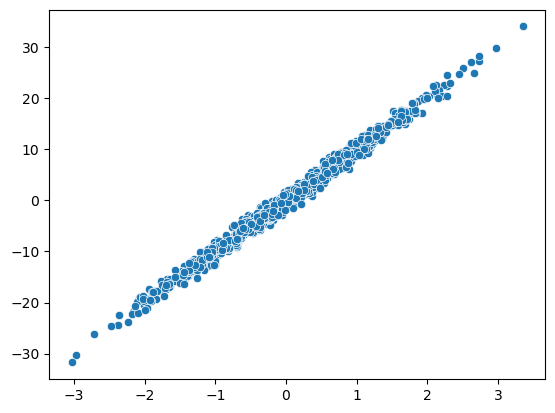

In [74]:
sns.scatterplot(x=Z, y=X)

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

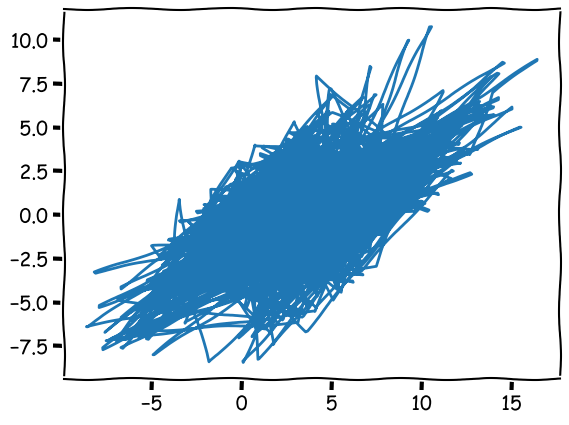

In [153]:
with plt.xkcd():
    plt.plot(X, Y)